# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [43]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import isnan, when, count, col, udf, countDistinct, max, min, avg, desc
from pyspark.sql import functions as F
from pyspark.sql.types import IntegerType, TimestampType, FloatType

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.feature import Normalizer, VectorAssembler

import datetime

In [7]:
# create a Spark session
spark = SparkSession.builder \
    .master("local") \
    .appName("Creating Features") \
    .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [8]:
datafile = "mini_sparkify_event_data.json"
df = spark.read.json(datafile)
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [4]:
df.head(3)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30'),
 Row(artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9'),
 Row(artist='Adam Lambert', auth='Logged In', firstName='Colin', gender='M', itemInSession=51, lastName='Freeman', length=282.8273, level='paid', location='

In [5]:
# Check missing
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId| song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
| 58392|   0|     8346|  8346|            0|    8346| 58392|    0|    8346|     0|   0|        8346|        0|58392|     0|  0|     8346|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+



In [9]:
# Based on missing counts, there are 2 types of info missing:
# missing 58392: song/artist related info, this missing doesn't have direct impact for churn
# missing 8346: missing user registration info, since it's predicting churn, an account needs to be established, so it's better to remove these records
df = df.filter(df.registration.isNotNull())
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId| song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
| 50046|   0|        0|     0|            0|       0| 50046|    0|       0|     0|   0|           0|        0|50046|     0|  0|        0|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+



In [7]:
print((df.count(), len(df.columns)))

(278154, 18)


# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [8]:
df.groupBy('page').count().orderBy('count').show()

+--------------------+------+
|                page| count|
+--------------------+------+
|              Cancel|    52|
|Cancellation Conf...|    52|
|    Submit Downgrade|    63|
|      Submit Upgrade|   159|
|               Error|   252|
|       Save Settings|   310|
|               About|   495|
|             Upgrade|   499|
|                Help|  1454|
|            Settings|  1514|
|           Downgrade|  2055|
|         Thumbs Down|  2546|
|              Logout|  3226|
|         Roll Advert|  3933|
|          Add Friend|  4277|
|     Add to Playlist|  6526|
|                Home| 10082|
|           Thumbs Up| 12551|
|            NextSong|228108|
+--------------------+------+



In [9]:
# Find some cancel/churn users
df.filter(df.page == 'Cancellation Confirmation').show(3)

+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+--------------------+-------------+---------+----+------+-------------+--------------------+------+
|artist|     auth|firstName|gender|itemInSession|lastName|length|level|            location|method|                page| registration|sessionId|song|status|           ts|           userAgent|userId|
+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+--------------------+-------------+---------+----+------+-------------+--------------------+------+
|  null|Cancelled|   Adriel|     M|          104| Mendoza|  null| paid|  Kansas City, MO-KS|   GET|Cancellation Conf...|1535623466000|      514|null|   200|1538943990000|"Mozilla/5.0 (Mac...|    18|
|  null|Cancelled|    Diego|     M|           56|   Mckee|  null| paid|Phoenix-Mesa-Scot...|   GET|Cancellation Conf...|1537167593000|      540|null|   200|1539033046000|"Mozilla/5.0 (iPh...|    32|
|  nu

In [14]:
# Track 1 churn userid to see all events
demo1 = df.filter(df.userId == 18)
demo1.groupBy('page').count().orderBy('count').show()

+--------------------+-----+
|                page|count|
+--------------------+-----+
|Cancellation Conf...|    1|
|               About|    1|
|         Thumbs Down|    1|
|       Save Settings|    1|
|              Cancel|    1|
|                Help|    1|
|           Downgrade|    3|
|            Settings|    5|
|              Logout|    7|
|          Add Friend|   10|
|     Add to Playlist|   14|
|                Home|   19|
|           Thumbs Up|   20|
|            NextSong|  429|
+--------------------+-----+



In [15]:
# Track the time trend

# Convert TS
convert_ts = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0), TimestampType())
demo1 = demo1.withColumn("Time", convert_ts(demo1.ts))

# Check Events                 
demo1.filter(~demo1.page.isin(['NextSong'])).select('page', 'ts', 'Time').show(100)

+--------------------+-------------+-------------------+
|                page|           ts|               Time|
+--------------------+-------------+-------------------+
|                Home|1538499917000|2018-10-02 12:05:17|
|            Settings|1538500856000|2018-10-02 12:20:56|
|            Settings|1538502021000|2018-10-02 12:40:21|
|           Thumbs Up|1538503942000|2018-10-02 13:12:22|
|           Thumbs Up|1538505045000|2018-10-02 13:30:45|
|              Logout|1538506325000|2018-10-02 13:52:05|
|                Home|1538506468000|2018-10-02 13:54:28|
|     Add to Playlist|1538506989000|2018-10-02 14:03:09|
|           Thumbs Up|1538510861000|2018-10-02 15:07:41|
|           Thumbs Up|1538511199000|2018-10-02 15:13:19|
|          Add Friend|1538512086000|2018-10-02 15:28:06|
|          Add Friend|1538512087000|2018-10-02 15:28:07|
|           Thumbs Up|1538512287000|2018-10-02 15:31:27|
|           Thumbs Up|1538513832000|2018-10-02 15:57:12|
|           Thumbs Up|153851535

### Based on concellation confirmation happened last, assuming each userID churn can be defined by the occurance of 'cancel'
### In other words, this analysis will not consider time relation of events, also not considering returned (previous cancelled) user

In [16]:
# Tag churn transaction
def_churn = udf(lambda x: 1 if x=='Cancellation Confirmation' else 0, IntegerType())
demo1 = demo1.withColumn("Churn", def_churn(demo1.page))

# Check results                 
demo1.filter(demo1.page.isin(['Cancellation Confirmation', 'Home', 'Settings'])).select('page', 'ts', 'Time', 'churn').show(100)

+--------------------+-------------+-------------------+-----+
|                page|           ts|               Time|churn|
+--------------------+-------------+-------------------+-----+
|                Home|1538499917000|2018-10-02 12:05:17|    0|
|            Settings|1538500856000|2018-10-02 12:20:56|    0|
|            Settings|1538502021000|2018-10-02 12:40:21|    0|
|                Home|1538506468000|2018-10-02 13:54:28|    0|
|                Home|1538517546000|2018-10-02 16:59:06|    0|
|                Home|1538517567000|2018-10-02 16:59:27|    0|
|                Home|1538518184000|2018-10-02 17:09:44|    0|
|            Settings|1538523319000|2018-10-02 18:35:19|    0|
|                Home|1538554143000|2018-10-03 03:09:03|    0|
|                Home|1538580606000|2018-10-03 10:30:06|    0|
|                Home|1538580843000|2018-10-03 10:34:03|    0|
|                Home|1538585623000|2018-10-03 11:53:43|    0|
|                Home|1538586493000|2018-10-03 12:08:13

In [17]:
# Apply the created column to the whole dataset - Tag churn transaction
df = df.withColumn("Time", convert_ts(df.ts))
df = df.withColumn("Churn", def_churn(df.page))
df.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', Time=datetime.datetime(2018, 9, 30, 19, 1, 57), Churn=0)

In [18]:
# Tag churn for all transactions for user id that churned

# create churn and non-churn
churn_id = df.filter(df.Churn==1).select('userId')
churn_list = [row['userId'] for row in churn_id.collect()]
df = df.withColumn("ID_Churn", when(col('userId').isin(churn_list), 1).otherwise(0))

In [15]:
# checking ID tags
df.filter(df.userId == 18).show(5)

+--------------------+---------+---------+------+-------------+--------+---------+-----+------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+-------------------+-----+--------+
|              artist|     auth|firstName|gender|itemInSession|lastName|   length|level|          location|method|    page| registration|sessionId|                song|status|           ts|           userAgent|userId|               Time|Churn|ID_Churn|
+--------------------+---------+---------+------+-------------+--------+---------+-----+------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+-------------------+-----+--------+
|                null|Logged In|   Adriel|     M|            0| Mendoza|     null| paid|Kansas City, MO-KS|   GET|    Home|1535623466000|      242|                null|   200|1538499917000|"Mozilla/5.0 (Mac...|    18|2018-10-02 12:05:17|    

### Exploring

In [19]:
# Check transaction counts
df.groupBy('ID_Churn').count().show()

+--------+------+
|ID_Churn| count|
+--------+------+
|       1| 44864|
|       0|233290|
+--------+------+



In [20]:
# Check unique Usder ID count
df.filter(df.ID_Churn==1).agg(countDistinct(col("userID")).alias("count")).show()
df.filter(df.ID_Churn==0).agg(countDistinct(col("userID")).alias("count")).show()

+-----+
|count|
+-----+
|   52|
+-----+

+-----+
|count|
+-----+
|  173|
+-----+



In [22]:
print('Churn: ', 44864/52, 'Non-Churn: ', 233290/173)

Churn:  862.7692307692307 Non-Churn:  1348.4971098265896


### Even transaction churn/non-churn is about 1:5, unique ID churn/non-churn is only about 1:3, so averge user activity(page count) count could be an indicator

In [18]:
# Check overall page activity type
df.filter(df.ID_Churn==1).select('page').groupBy('page').count().orderBy('count').show()
df.filter(df.ID_Churn==0).select('page').groupBy('page').count().orderBy('count').show()

+--------------------+-----+
|                page|count|
+--------------------+-----+
|    Submit Downgrade|    9|
|               Error|   32|
|      Submit Upgrade|   32|
|Cancellation Conf...|   52|
|              Cancel|   52|
|               About|   56|
|       Save Settings|   58|
|             Upgrade|  112|
|                Help|  239|
|            Settings|  270|
|           Downgrade|  337|
|         Thumbs Down|  496|
|              Logout|  553|
|          Add Friend|  636|
|         Roll Advert|  967|
|     Add to Playlist| 1038|
|                Home| 1672|
|           Thumbs Up| 1859|
|            NextSong|36394|
+--------------------+-----+

+----------------+------+
|            page| count|
+----------------+------+
|Submit Downgrade|    54|
|  Submit Upgrade|   127|
|           Error|   220|
|   Save Settings|   252|
|         Upgrade|   387|
|           About|   439|
|            Help|  1215|
|        Settings|  1244|
|       Downgrade|  1718|
|     Thumbs Down|  

In [19]:
# Check other potential attributes that looks promising
df.select('ID_Churn', 'gender').groupBy('ID_Churn', 'gender').count().orderBy('count').show()
df.select('ID_Churn', 'level').groupBy('ID_Churn', 'level').count().orderBy('count').show()
df.filter(df.ID_Churn==1).select('itemInSession').summary().show()
df.filter(df.ID_Churn==0).select('itemInSession').summary().show()
df.filter(df.ID_Churn==1).select('length').summary().show()
df.filter(df.ID_Churn==0).select('length').summary().show()

+--------+------+------+
|ID_Churn|gender| count|
+--------+------+------+
|       1|     F| 19168|
|       1|     M| 25696|
|       0|     M| 97880|
|       0|     F|135410|
+--------+------+------+

+--------+-----+------+
|ID_Churn|level| count|
+--------+-----+------+
|       1| free| 12388|
|       1| paid| 32476|
|       0| free| 43333|
|       0| paid|189957|
+--------+-----+------+

+-------+------------------+
|summary|     itemInSession|
+-------+------------------+
|  count|             44864|
|   mean|109.23299304564907|
| stddev|122.72170867995432|
|    min|                 0|
|    25%|                26|
|    50%|                66|
|    75%|               147|
|    max|               889|
+-------+------------------+

+-------+------------------+
|summary|     itemInSession|
+-------+------------------+
|  count|            233290|
|   mean| 115.9888465000643|
| stddev|131.15066994654808|
|    min|                 0|
|    25%|                27|
|    50%|                

### Nothing stands out here by count or percentage, probably needs to aggregate per UserID to see more

In [25]:
df.createOrReplaceTempView("df_explore")

In [22]:
df.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', Time=datetime.datetime(2018, 9, 30, 19, 1, 57), Churn=0, ID_Churn=0)

In [26]:
ana1 = spark.sql('''
          SELECT DISTINCT userId, ID_Churn, MAX(Time) AS Max_Time, MIN(Time) AS Min_Time,
          AVG(length) AS AVG_LENGTH,
          AVG(itemInSession) AS AVG_ITEM
          FROM df_explore
          GROUP BY userID, ID_Churn
          '''
          )

In [55]:
ana1 = ana1.withColumn("life_hour", (F.unix_timestamp("Max_Time") - F.unix_timestamp("Min_Time"))/3600.0)

In [28]:
ana1_df=ana1.toPandas()

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000002C962A14400>,
      dtype=object)

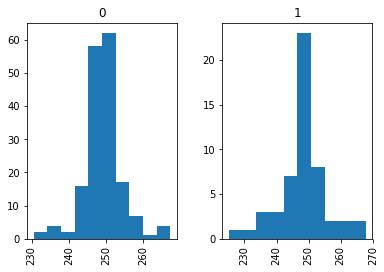

In [49]:
ana1_df['AVG_LENGTH'].hist(by=ana1_df["ID_Churn"])

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000002C962DB86A0>,
      dtype=object)

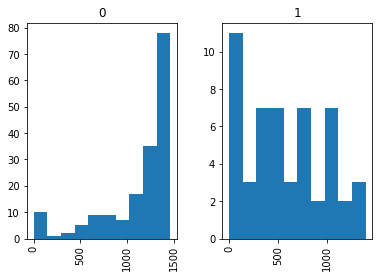

In [52]:
ana1_df['life_hour'].hist(by=ana1_df["ID_Churn"])

array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000114D0BD8D68>,
      dtype=object)

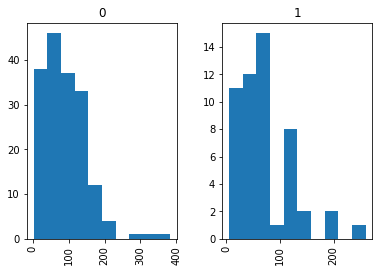

In [30]:
ana1_df['AVG_ITEM'].hist(by=ana1_df["ID_Churn"])

### Gender, Level and itemInSession looks promising, length doesn't matter for churn

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

### Create transactional feature tag

In [31]:
# Create features based on page info
p1 = udf(lambda x: 1 if x=='Add Friend' else 0, IntegerType())
p2 = udf(lambda x: 1 if x=='Add to Playlist' else 0, IntegerType())
p3 = udf(lambda x: 1 if x=='Downgrade' else 0, IntegerType())
p4 = udf(lambda x: 1 if x=='Upgrade' else 0, IntegerType())
p5 = udf(lambda x: 1 if x=='Error' else 0, IntegerType())
p6 = udf(lambda x: 1 if x=='Help' else 0, IntegerType())
p7 = udf(lambda x: 1 if x=='Home' else 0, IntegerType())
p8 = udf(lambda x: 1 if x=='Thumbs Up' else 0, IntegerType())
p9 = udf(lambda x: 1 if x=='Thumbs Down' else 0, IntegerType())

# Gender
f1 = udf(lambda x: 1 if x=='F' else 0, IntegerType())
# Level
f2 = udf(lambda x: 1 if x=='paid' else 0, IntegerType())

In [32]:
df = df.withColumn("AF", p1(df.page))
df = df.withColumn("AP", p2(df.page))
df = df.withColumn("DN", p3(df.page))
df = df.withColumn("UP", p4(df.page))
df = df.withColumn("ER", p5(df.page))
df = df.withColumn("HP", p6(df.page))
df = df.withColumn("HM", p7(df.page))
df = df.withColumn("TU", p8(df.page))
df = df.withColumn("TD", p9(df.page))
df = df.withColumn("Female", f1(df.gender))
df = df.withColumn("Paid", f2(df.level))

### Aggregate to create user id level data

In [34]:
df.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', Time=datetime.datetime(2018, 9, 30, 19, 1, 57), Churn=0, ID_Churn=0, AF=0, AP=0, DN=0, UP=0, ER=0, HP=0, HM=0, TU=0, TD=0, Female=0, Paid=1)

In [33]:
df.createOrReplaceTempView("df_table")

### A few notes about created features:  
* For page type, it's for different activity distribution, here just do simple count of special events and total event, later normalization should take care of scaling part  
* Female should be the same per User ID, nothing to aggregate
* Item in session is taking the user averge
* pay level is a little complicated, because a user can go from pay to free then go back and so forth, since there is no time tracking here, it will count the transaction pecentage when leve is paid
* song/artist info is not considered because it's probably not related to churn 
* session id is not considered, technically we could use the unique count, then it will be strongly correlated with ts, since time is not factored here, this info is ignored to avoid complication

In [38]:
df2 = spark.sql('''
          SELECT DISTINCT userId, ID_Churn AS label, Female,
          SUM(Paid)/COUNT(*) AS PayRate,
          SUM(AF) AS AFC, SUM(AP) AS APC, SUM(DN) AS DNC, SUM(UP) AS UPC,
          SUM(ER) AS ERC, SUM(HP) AS HPC, SUM(HM) AS HMC, SUM(TU) AS TUC, SUM(TD) AS TDC,
          COUNT(*) AS TOTALC,
          AVG(itemInSession) AS AVG_ITEM,
          MAX(Time) AS Max_Time, MIN(Time) AS Min_Time
          FROM df_table
          GROUP BY userID, ID_Churn, Female
          '''
          )

In [39]:
df2 = df2.withColumn("life_hour", (F.unix_timestamp("Max_Time") - F.unix_timestamp("Min_Time"))/3600.0)

In [40]:
df2.head()

Row(userId='61', label=0, Female=0, PayRate=0.645242914979757, AFC=26, APC=50, DNC=10, UPC=6, ERC=2, HPC=10, HMC=75, TUC=78, TDC=11, TOTALC=1976, AVG_ITEM=156.61993927125505, Max_Time=datetime.datetime(2018, 11, 28, 11, 54, 4), Min_Time=datetime.datetime(2018, 10, 1, 20, 56, 6), life_hour=1383.966111111111)

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [41]:
train, test = df2.randomSplit([0.6, 0.4], seed=12345)

In [44]:
# Building pipeline

assembler = VectorAssembler(inputCols=['AFC', 'APC', 'DNC', 'UPC', 'ERC', 'HPC', 'HMC', 'TUC', 'TDC', 'TOTALC', 'Female', 'AVG_ITEM', 'PayRate', 'life_hour'], outputCol="Features")
scaler = Normalizer(inputCol="Features", outputCol="features")
lr =  LogisticRegression(maxIter=10, regParam=0.0, elasticNetParam=0)

pipeline = Pipeline(stages=[assembler, scaler, lr])

In [45]:
# Cross Validation
paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.0, 0.1, 0.2]) \
    .build()


crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=4)

In [46]:
m2 = crossval.fit(train)

In [47]:
m2.avgMetrics

[0.7493605470863353, 0.7073038834408536, 0.6693814722843591]

In [48]:
# Scoring test and train data
results = m2.transform(test)
train_results = m2.transform(train)

In [258]:
results

DataFrame[userId: string, label: int, Female: int, PayRate: double, AFC: bigint, APC: bigint, DNC: bigint, UPC: bigint, ERC: bigint, HPC: bigint, HMC: bigint, TUC: bigint, TDC: bigint, TOTALC: bigint, AVG_ITEM: double, features: vector, rawPrediction: vector, probability: vector, prediction: double]

In [49]:
results.select('label', 'prediction').groupBy('label', 'prediction').count().show()
train_results.select('label', 'prediction').groupBy('label', 'prediction').count().show()

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    1|       0.0|   14|
|    0|       0.0|   69|
|    1|       1.0|    3|
|    0|       1.0|    6|
+-----+----------+-----+

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    1|       0.0|   21|
|    0|       0.0|   92|
|    1|       1.0|   14|
|    0|       1.0|    6|
+-----+----------+-----+



In [50]:
# Validation Peformance
tp, fp, fn, tn = 3, 6, 14, 69
recall = tp/(tp+fn)
precision = tp/(tp+fp)
f1 = 2/(1/recall + 1/precision)
acc = (tp+tn)/(tp+fp+fn+tn)
print("Test: Recall {}, Precision {}, f1 {}, Accuracy {}".format(recall, precision, f1, acc))

Test: Recall 0.17647058823529413, Precision 0.3333333333333333, f1 0.23076923076923078, Accuracy 0.782608695652174


In [51]:
# Training data Performance
tp2, fp2, fn2, tn2 = 14, 6, 21, 92
recall2 = tp2/(tp2+fn2)
precision2 = tp2/(tp2+fp2)
f12 = 2/(1/recall2 + 1/precision2)
acc2 = (tp2+tn2)/(tp2+fp2+fn2+tn2)
print("Train: Recall {}, Precision {}, f1 {}, Accuracy {}".format(recall2, precision2, f12, acc2))

Train: Recall 0.4, Precision 0.7, f1 0.509090909090909, Accuracy 0.7969924812030075


### Check model parameters

In [60]:
bestm = m2.bestModel
bestm.stages[-1].coefficients

DenseVector([-56.1765, -51.1284, -13.1327, 229.7937, -201.7866, -8.9006, 8.9837, 0.3432, 176.4148, 1.1693, -16.8954, 0.6643, 383.0114, -1.9204])

In [62]:
#['AFC', 'APC', 'DNC', 'UPC', 'ERC', 'HPC', 'HMC', 'TUC', 'TDC', 'TOTALC', 'Female', 'AVG_ITEM', 'PayRate', 'life_hour']

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.